# Orbits 1: Orbits in Spherical Gravitational Potentials

Author(s): Adrian Price-Whelan


## Learning goals

The main goal for this tutorial is to introduce the concept of orbits and numerically-computed trajectories using spherical gravitational potential models.


## Introduction

For many contexts in Galactic dynamics, the orbital trajectory of an object (star, planet, star cluster, satellite galaxy, etc.) is a fundamental tool for studying and interpreting the dynamical state, evolution, or initial conditions of a gravitational system. However, in general, we cannot directly observe any appreciable changes in position or velocity of a gravitating body over human timescales. As Galactic dynamicists, we therefore effectively only have access to measurements of a single kinematic snapshot of any dynamical system. With a kinematic snapshot and a model for the overall mass distribution of a system, we then seek to compute the past or future trajectories of the constituent bodies and use this information to, for example, refine our mass model, interpret kinematic features, or predict the evolution (past or present) of a system. In many such regimes, the mass of the orbiting body is small relative to the larger mass distribution in which it orbits (e.g., a star within a Galaxy). It is therefore often sufficient to treat an orbiting body as an effectively massless "tracer" particle whose trajectory is set by the broader mass distribution, and which does not cause any appreciable backreaction of the host system. (In later workshops, we will explore cases in which this assumption breaks down, such as with the Milky Way–LMC interaction.) In this context, a common goal is to compute the time-dependent position and velocity — the orbit — of an effectively massless body orbiting within an external gravitational field.

While galaxies are actually composed of a large number of discrete point masses and structures (and we do not know the smallest size of dark matter substructures), it is often sufficient to model the mass distribution of a galaxy by considering smooth mass distributions (where the smoothing length scale is much smaller than the size of a galaxy, <<100 kpc, but larger than the spacing between massive structures, >>1 pc). As we saw in the lectures, and as you might recall from past Mechanics courses, the fundamental quantity in the context of computing orbits is the acceleration field $\boldsymbol{a}(\boldsymbol{x})$ specified often as a function of a three-dimensional position $\boldsymbol{x}$. In convervative systems — or effectively conservative systems: neglecting star formation and death/supernovae for stars, and assuming that dark matter acts effectively like a collisionless fluid, the massive objects that make up a galaxy ineract only through gravitational interactions — the (vector) acceleration field can be directly computed as the gradient of the (scalar) gravitational potential $\Phi(\boldsymbol{x})$ of a system:

$$
\boldsymbol{a}(\boldsymbol{x}) = -\nabla \Phi(\boldsymbol{x})
$$

where the gravitational potential (sometimes later abbreviated simply as "potential") is related to the mass (density) distribution through Poisson's equation:

$$
\nabla^2 \Phi(\boldsymbol{x}) = 4\pi \, G \, \rho(\boldsymbol{x})
$$

While the acceleration or gravitational field is "closer" to the dynamics (in that it is the force on a body that determines how it responds) and the density field is a direct representation of the mass distribution, it is often easier to work with and visualize the gravitational potential. 

In this tutorial, we will introduce some commonly-used spherical gravitational potential models, compute the orbits of particles in some of these models, and analyze the properties of orbits in spherical models.


## Terminology and Notation

- 3D position: $\boldsymbol{x}$
- 3D velocity: $\boldsymbol{v}$
- 6D phase-space position: $\boldsymbol{w} = (\boldsymbol{x}, \boldsymbol{v})$
- Orbit: $\boldsymbol{w}(t) = (\boldsymbol{x}(t), \boldsymbol{v}(t))$
- Gravitational potential: $\Phi(\boldsymbol{x})$
- Mass density: $\rho(\boldsymbol{x})$
- Spherical radius: $r = |\boldsymbol{x}|$

### Notebook Setup and Package Imports

In [1]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.time import Time

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp

## Orbits in a Point Mass Potential

TODO:
- Introduce problem, what ODE we have to solve
- Form of the potential
- Mass enclosed
- Circular velocity
- Units

One of the simplest spherical mass models is that of a point mass, in which:

$$
\Phi(r) = - \frac{G \, M}{r}
$$

or equivalently

$$
\Phi(\boldsymbol{x}) = - \frac{G \, M}{|\boldsymbol{x}|}
$$

and the acceleration field is

$$
\begin{align}
\boldsymbol{a}(\boldsymbol{x}) &= -\nabla \Phi(\boldsymbol{x}) \\
    & = - \frac{G \, M}{|\boldsymbol{x}|^3} \, \boldsymbol{x} \\
    & = - \frac{G \, M}{r^2} \, \hat{\boldsymbol{x}}
\end{align}
$$

Let's implement a function that computes the point mass acceleration at any 3D position, given a mass M:

In [2]:
from astropy.constants import G

def ptmass_acceleration(xyz, M):
    """
    This function computes the 3D acceleration vector at a 
    position or an array of positions "xyz" from a point mass 
    with mass "M" at the origin.
    
    Parameters
    ----------
    xyz : array-like
        This should have shape (3, ...)
    M : numeric
        The total mass of the point mass.
    
    """
    r3 = np.sum(xyz**2, axis=0) ** (3/2)
    dPhi_dx = G * M * xyz / r3
    return -dPhi_dx

In the function definition above, note that we use the gravitational constant `G` as imported from `astropy.constants`. This object is more than just a number: It is a special kind of Python/Astropy object called a [`Quantity`](https://docs.astropy.org/en/stable/units/quantity.html#quantity), which carries along and propagates units. For example, if we view the representation of the gravitational constant:

In [3]:
G

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

we see that it also displays the units $\frac{\textrm{m}^3}{\textrm{kg} \, \textrm{s}^2}$! When we call the `ptmass_acceleration()` function, this means that we should pass in a position and a point mass with units, and we will get out an acceleration that we can easily convert to other unit representations. For example, assuming the Earth is on the x-axis in some solar system coordinate system, we can evaluate the acceleration felt on Earth by the Sun as:

In [4]:
earth_pos = [1, 0, 0] * u.au  # 1 Astronomical Unit along the x axis
earth_acc = ptmass_acceleration(earth_pos, M=1 * u.Msun)
earth_acc

<Quantity [-6.6743e-11, -0.0000e+00, -0.0000e+00] m3 solMass / (AU2 kg s2)>

This is a strange unit! By default, `astropy.units` propagates units but does not do any conversion or simplification of the units. For example, here the $\textrm{M}_\odot$ in the numerator should cancel the kg in the denominator. If we want to convert this into something more readable, we use the `.to()` method and specify the desired output unit:

In [5]:
earth_acc.to(u.km / u.s**2)

<Quantity [-5.93008352e-06, -0.00000000e+00, -0.00000000e+00] km / s2>

Some other examples of acceleration units:

In [6]:
earth_acc.to(u.au / u.yr**2)

<Quantity [-39.47692641,  -0.        ,  -0.        ] AU / yr2>

In [7]:
earth_acc.to(u.km / u.s / u.day)

<Quantity [-0.51235922, -0.        , -0.        ] km / (d s)>

### Example: Compute the acceleration from the Sun at the current (right now!) location of Mars

Get a representation of the current time using `astropy.time.Time()`:

In [8]:
now = Time.now()
now.mjd

59388.85419509177

We will use Astropy (`astropy.coordinates`) to retrieve the position of Mars: In the background, this queries the JPL ephemeris for us. So we can retrieve the position of Mars at the current time using:

In [9]:
mars_pos = coord.get_body('mars', now)
mars_pos

<SkyCoord (GCRS: obstime=2021-06-23 20:30:02.455929, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    (130.03484747, 19.67896253, 2.39089604)>

(this works for other solar system bodies - try it! Swap 'mars' out for, e.g., 'saturn')

By default, the position of Mars is returned to us in a Geocentric (Earth-centric) coordinate system. We need to convert this to a Heliocentric coordinate system so we can compute the acceleration from the Sun (assuming it is at the origin). We will convert it to Heliocentric Ecliptic coordinates:

In [10]:
mars_ecl = mars_pos.transform_to(coord.HeliocentricTrueEcliptic(obstime=now))

Now we can retrieve a Cartesian representation of the Ecliptic position of Mars, and use this to compute the acceleration:

In [11]:
mars_xyz_now = mars_ecl.cartesian.xyz
mars_xyz_now

<Quantity [-1.4075756 ,  0.88611862,  0.05310042] AU>

In [12]:
mars_acc = ptmass_acceleration(mars_xyz_now, M=1*u.Msun)
mars_acc.to(u.km / u.s / u.day)

<Quantity [ 0.15649212, -0.09851732, -0.00590362] km / (d s)>

### Computing an orbit in the point mass potential

The orbit of a massless particle in any acceleration field can be computed by solving the differential equation

$$
\begin{align}
\ddot{\boldsymbol{x}} &= \boldsymbol{a}(\boldsymbol{x}) \\
\ddot{\boldsymbol{x}} &= -\nabla \Phi(\boldsymbol{x})
\end{align}
$$

For a point mass, this is sometimes referred to as the "Kepler problem": This is a special case in which we could write down an analytic expression for the position of the particle at any time, given a set of initial conditions. However, generically, this differential equation cannot be solved analytically and we must instead resort to numerical integration tools. In this context, it is often easier to reduce the 2nd-order differential equation for postion expressed above into a pair of coupled 1st-order differential equations for position and velocity (or momentum). We do this be introducing an auxiliary variable to represent the 3D velocity, so that the relevant system of differential equations we need to solve is now:

$$
\begin{align}
\dot{\boldsymbol{x}} &= \boldsymbol{v} \\
\dot{\boldsymbol{v}} &= -\nabla \Phi(\boldsymbol{x}) 
\end{align}
$$

We can compress this into a single expression by defining the "phase-space position" $\boldsymbol{w} = (\boldsymbol{x}, \boldsymbol{v})$ such that:

$$
\begin{align}
\dot{\boldsymbol{w}} &= (\dot{\boldsymbol{x}}, \dot{\boldsymbol{v}}) \\
&= (\boldsymbol{v}, -\nabla \Phi(\boldsymbol{x}))
\end{align}
$$

Our goal then is to compute $\boldsymbol{w}(t)$ given initial conditions $\boldsymbol{w}_0$. There are many standard tools available for solving problems like this numerically. This is sometimes called an "initial value problem," or ODE integration. Here, we will define a function to compute the time-derivative of $\boldsymbol{w}$ and use `scipy.integrate.solve_ivp()` to compute the orbital trajectory of a particle. 

The function we defined above to compute the point mass acceleration only does half of what we need: We need to define a new function `ptmass_F()` that takes the full phase-space position $\boldsymbol{w}$ and returns its time-derivative, $\dot{\boldsymbol{w}} = (\boldsymbol{v}, -\nabla \Phi(\boldsymbol{x}))$. `solve_ivp()` also requires that the function accept a first argument, the time `t`, which in this case we will include in the definition but ignore in any expressions.

Also, `solve_ivp()` unfortunately does not support `astropy.units`, so we will have to re-implement the point mass acceleration in a way that takes only regular Python numbers. To avoid having to specify units for both `G` and the mass `M`, we will have this function accept the combined parameter `GM = G * M`:

In [13]:
def ptmass_F(t, w, GM):
    """
    Parameters
    ----------
    t : numeric
        The current time during the integration.
    w : array-like
        The phase-space position, which should have 6 elements.
    GM : numeric
        Mass times the gravitational constant.
    
    """
    xyz = w[:3]
    vxyz = w[3:]
    
    r3 = np.sum(xyz**2, axis=0) ** (3/2)
    dPhi_dx = GM * xyz / r3
    return np.concatenate([vxyz, -dPhi_dx])

Even though we cannot use `astropy.units` to keep track of units internally, we can still use it to do unit conversions before we pass inputs to the function, or with the resulting orbital time series that we compute. For this, it helps to work in a consistent unit system (a set of base units that represent length, mass, and time). Here, since we are using Solar System examples, a good unit system is AU, $\textrm{M}_\odot$, and years:

In [14]:
unitsys = [u.au, u.Msun, u.year]

We now have all of the pieces we need to compute an orbit in the point mass potential! How then should we choose initial conditions for a trial orbit? One simple option is to pick a location, and start a particle on a circular orbit that goes through that location. 

An important property of spherical mass distributions is the concept of the *circular velocity* $v_{\rm circ}(r)$, which is defined to be the speed of a test particle on a circular orbit at radius $r$. The circular velocity can be found by equating the centripetal acceleration $\frac{v^2}{r}$ with the (absolute value of the) acceleration from the gravitational potential $\nabla \Phi$

$$
\begin{align}
\frac{v^2}{r} &= \left|\frac{\textrm{d}\Phi}{\textrm{d}r}\right| \\
v_{\rm circ}(r) &= \sqrt{r \, \left|\frac{\textrm{d}\Phi}{\textrm{d}r}\right|}
\end{align}
$$

For the point mass potential, this is simply:

$$
v_{\rm circ}(r) = \sqrt{\frac{G\,M}{r}}
$$

### Example: Compute the circular velocity in at $r=1.6~\textrm{AU}$ in the Solar System in AU/year

In [15]:
r0 = 1.6 * u.au
M = 1 * u.Msun
v_circ = np.sqrt(G * M / r0).decompose(unitsys)
v_circ

<Quantity 4.96720032 AU / yr>

The `.decompose()` method allows us to represent a `Quantity` in a given unit system without having to construct the unit explicitly (here we just had to pass in the list of base units to `decompose()`).

We will now use this radius and circular velocity to construct 3D initial conditions that we will pass to `solve_ivp()` to compute the orbit of a test particle in the Solar System. We will start the particle on the x-axis ($y=z=0$) so that the velocity (perpendicular to the position vector) is purely in the $\hat{y}$ direction:

In [16]:
x0 = [
    r0.decompose(unitsys).value,  # x
    0,  # y
    0  # z
]
v0 = [
    0,  # vx
    v_circ.decompose(unitsys).value,  # vy
    0  # vz
]
w0 = np.concatenate((x0, v0))
w0

array([1.6       , 0.        , 0.        , 0.        , 4.96720032,
       0.        ])

Finally, we have to convert the combined amplitude parameter `GM` into our unit system:

In [17]:
GM = (G * M).decompose(unitsys).value
GM

39.476926408897626

The last thing we need to specify is the grid of times over which to compute the orbit. For this example, we will use 1024 equally spaced points between 0 and 10 years (the time unit in our unit system):

In [18]:
t_eval = np.linspace(0, 10, 1024)

In [19]:
soln = solve_ivp(
    ptmass_F, 
    y0=w0, 
    args=(GM, ),
    t_span=(t_eval.min(), t_eval.max()), 
    t_eval=t_eval
)

The returned Solution object `soln` now contains the orbit of our test particle (position and velocity) evaluated at all 1024 points in our time grid!

In [20]:
soln

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 302
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 9.77517107e-03, 1.95503421e-02, ...,
       9.98044966e+00, 9.99022483e+00, 1.00000000e+01])
 t_events: None
        y: array([[ 1.6       ,  1.5992633 ,  1.59705383, ...,  0.06984729,
         0.13068604,  0.19105318],
       [ 0.        ,  0.04854778,  0.09705102, ..., -1.0131682 ,
        -1.00630949, -0.99581922],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.15071659, -0.30129624, ...,  6.24044098,
         6.20344175,  6.14394252],
       [ 4.96720032,  4.96491324,  4.9580536 , ...,  0.5152315 ,
         0.88779149,  1.25802072],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
 y_events: None

The Scipy integrators use the variable "`y`" for any integration variables, so in this case `w = y`. To plot the position time series of the particle, we will plot two 2D projections of the 3D position: x-y and x-z:

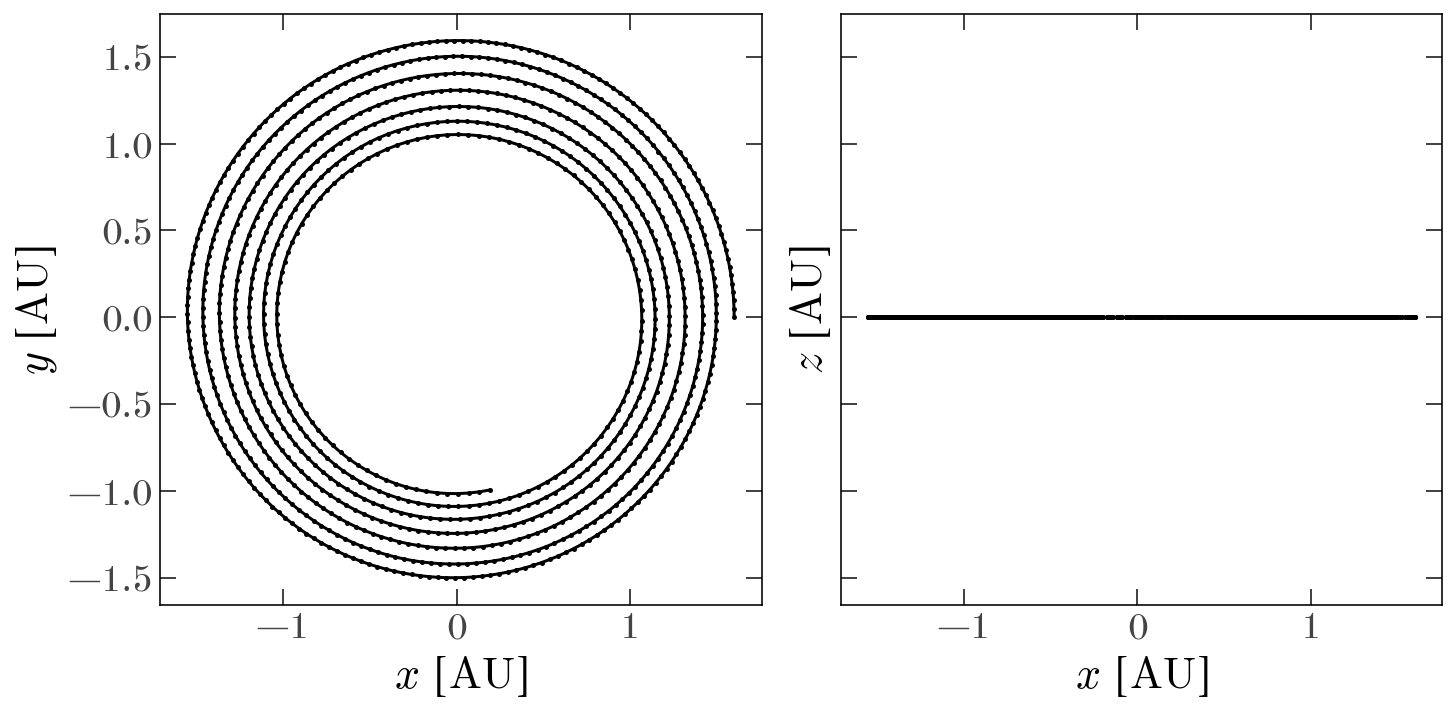

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

# x-y
axes[0].plot(soln.y[0], soln.y[1])
axes[0].set_xlabel(f'$x$ [{unitsys[0]:latex_inline}]')
axes[0].set_ylabel(f'$y$ [{unitsys[0]:latex_inline}]')

# x-z
axes[1].plot(soln.y[0], soln.y[2])
axes[1].set_xlabel(f'$x$ [{unitsys[0]:latex_inline}]')
axes[1].set_ylabel(f'$z$ [{unitsys[0]:latex_inline}]')

for ax in axes:
    ax.set_aspect('equal')

The orbit is confined to the x-y plane, as we might expect (we only gave the particle velocity in the y direction, starting from the x axis). However: **that doesn't look like a circular orbit**: The orbit in the x-y plane looks more like a spiral!?! This is a telltale sign of energy drift. The force on our test particle is conservative and time-independent, so the orbital energy should be conserved along the particle's orbit. Let's compute the total energy for this numerically-integrated orbit and see if it is constant. To do that, we will implement a function to evaluate the point mass potential energy (defined above), and the total energy (the sum of potential and kinetic energy) at any phase-space position:

In [22]:
def ptmass_potential(xyz, M):
    """
    Compute the potential energy from a point mass at the given
    position(s) ``xyz``.
    
    Parameters
    ----------
    xyz : quantity-like
    M : quantity-like
    """
    r = np.sqrt(np.sum(xyz**2, axis=0))
    return - G * M / r


def ptmass_total_energy(w, M, unitsys):
    """
    Compute the total energy (kinetic + potential) for phase-space 
    position(s) ``w``.
    
    Parameters
    ----------
    w : array-like
    M : quantity-like
    unitsys : list, collection
        A list or iterable containing the base units that define the
        adopted unit system. Order: length, mass, time
    """
    xyz = w[:3] * unitsys[0]
    vxyz = w[3:] * unitsys[0] / unitsys[2]
    E_kin = 0.5 * np.sum(vxyz ** 2, axis=0)
    E_pot = ptmass_potential(xyz, M)
    return E_kin + E_pot

We can now compute the energy for each point in the orbital time series, and the fractional energy change relative to the initial energy `dE`:

(1e-15, 1.0)

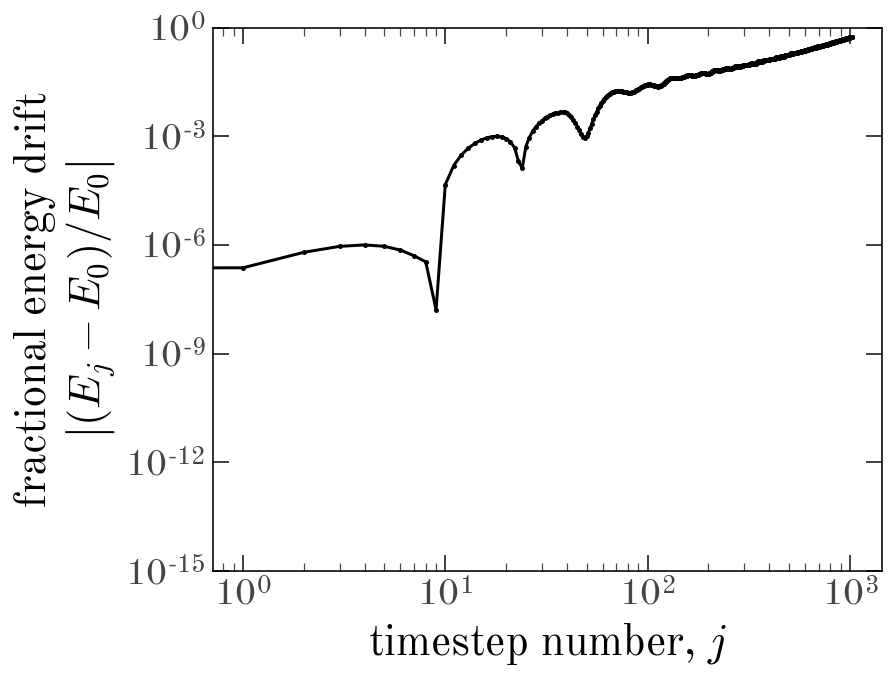

In [23]:
E = ptmass_total_energy(soln.y, M, unitsys)
dE = np.abs((E[1:] - E[0]) / E[0])

plt.figure(figsize=(6, 5))
plt.loglog(dE)
plt.xlabel('timestep number, $j$')
plt.ylabel('fractional energy drift\n' + r'$\left|(E_j - E_0) / E_0\right|$')
plt.ylim(1e-15, 1e0)

Aha! The energy of the computed orbit drifts steadily toward a nearly 100% change from the initial energy: This explains why the computed orbit does not look like a circular orbit, as we would expect. The fact that energy is not conserved is a consequence of the default integration method used by `solve_ivp()`: An (effectively) 4th-order Runge–Kutta method. Runge–Kutta methods are class of iterative schemes for computing approximate solutions for ordinary differential equations. However, they are approximate, and so these methods steadily accumulate errors. With `solve_ivp()`, we can control the error tolerance (the internal timestep used to perform the integration) using the function arguments `rtol` and `atol`, which set the threshold relative (rtol) and absolute (atol) error tolerances (see the [solve_ivp() documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) for more context).

Let's try re-running the orbit calculation, but with much smaller `rtol` and `atol` values (compared to the defaults of 1e-3 and 1e-6, respectively):

In [24]:
soln_tol = solve_ivp(
    ptmass_F, 
    y0=w0, 
    args=(GM, ),
    t_span=(t_eval.min(), t_eval.max()), 
    t_eval=t_eval,
    rtol=1e-12,
    atol=1e-8
)

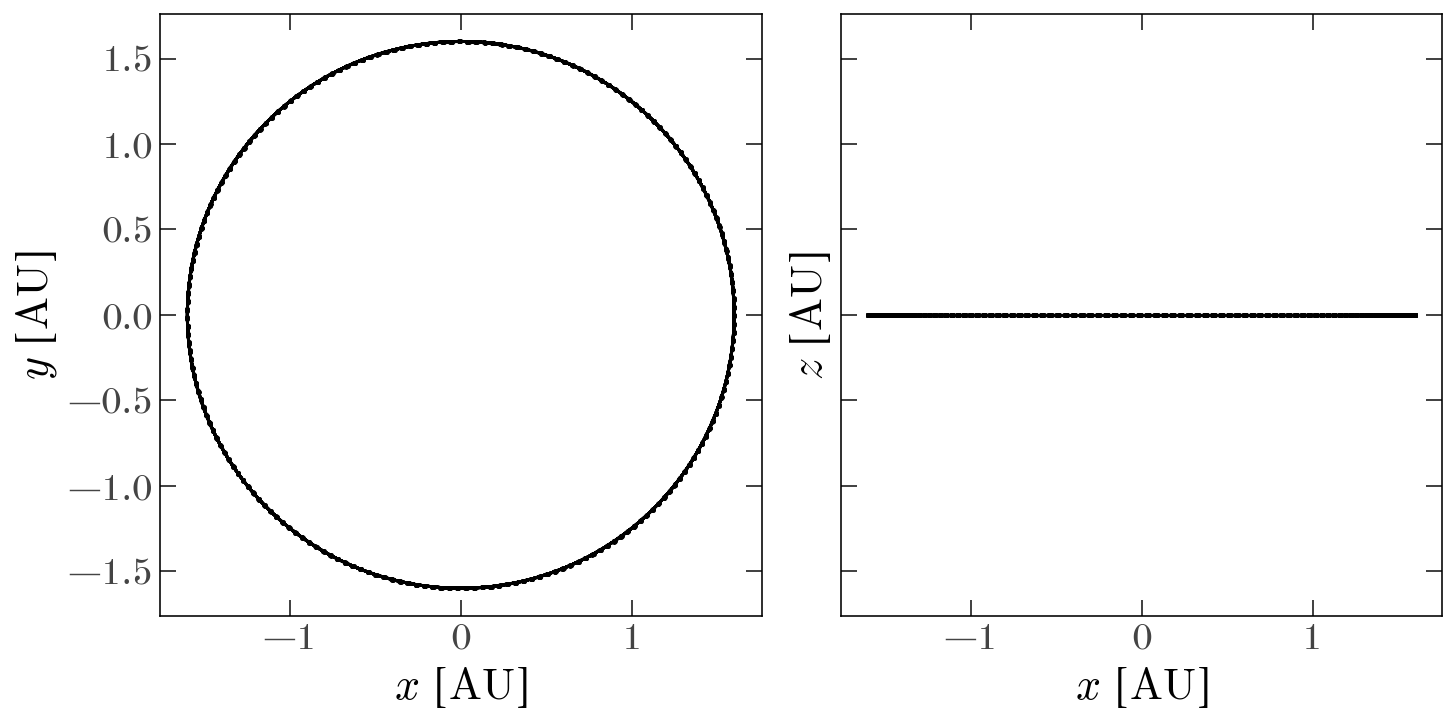

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

# x-y
axes[0].plot(soln_tol.y[0], soln_tol.y[1])
axes[0].set_xlabel(f'$x$ [{unitsys[0]:latex_inline}]')
axes[0].set_ylabel(f'$y$ [{unitsys[0]:latex_inline}]')

# x-z
axes[1].plot(soln_tol.y[0], soln_tol.y[2])
axes[1].set_xlabel(f'$x$ [{unitsys[0]:latex_inline}]')
axes[1].set_ylabel(f'$z$ [{unitsys[0]:latex_inline}]')

for ax in axes:
    ax.set_aspect('equal')

That looks much better! The orbit looks circular, and it visually appears to stay circular and planar for the duration of our integration window. 

We therefore expect the energy conservation to be preserved much more accurately for this case:

(1e-15, 1.0)

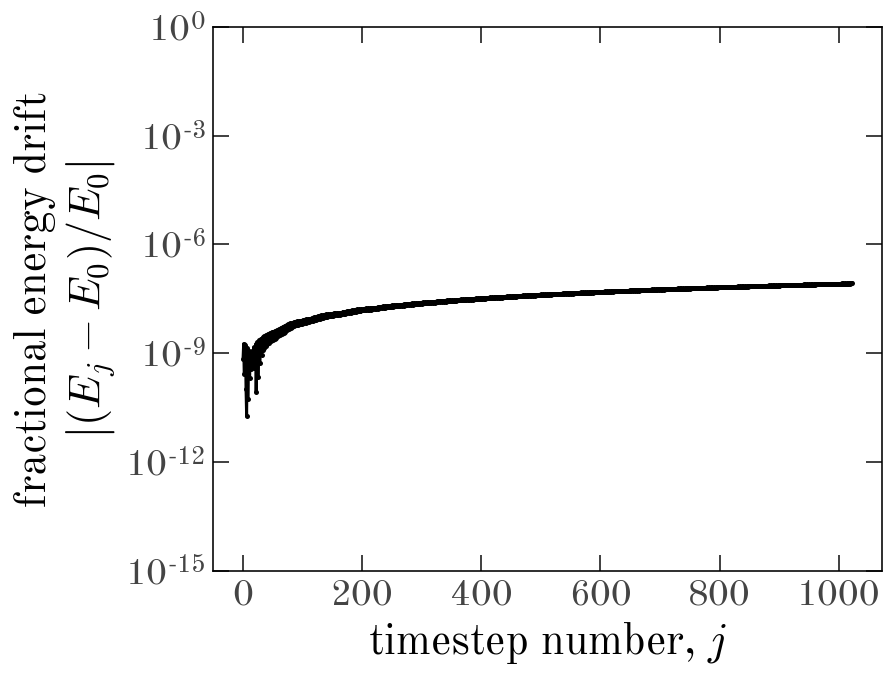

In [26]:
E = ptmass_total_energy(soln_tol.y, M, unitsys)
dE = np.abs((E[1:] - E[0]) / E[0])

plt.figure(figsize=(6, 5))
plt.semilogy(dE)
plt.xlabel('timestep number, $j$')
plt.ylabel('fractional energy drift\n' + r'$\left|(E_j - E_0) / E_0\right|$')
plt.ylim(1e-15, 1e0)

Indeed, by the end of our integration window, the energy changes by $<10^{-7}$ relative to the initial energy for this case (the axis limits are the same here as in the previous plot! Scroll up to compare the two plots).

## Integration Algorithms

Runge–Kutta is just one method...

Another class of powerful integration schemes ... symplectic. 

Leapfrog: 2nd order symplectic integrator

TODO: 
- symplectic vs. non
- implement Leapfrog
- introduce Plummer (next step up from Kepler)
    - Exercise: have students implement `plummer_gradient()` function
- demonstrate energy conservation with leapfrog

In [27]:
def leapfrog_integrate(func, w0, ts, func_args=()):
    w0 = np.asarray(w0)
    x0 = w0[:3]
    v0 = w0[3:]
    
    dt = np.diff(ts)[0]
    n_steps = len(ts) - 1
    
    # Initialize the velocity: evolve forward by 1/2 step
    F0 = func(ts[0], w0, *func_args)
    a0 = F0[ndim:]
    v_1_2 = v0 + a0 * dt / 2.
    
    ws = np.full((6, n_steps + 1), np.nan)
    ws[:3, 0] = x0
    ws[3:, 0] = v0
    
    x_im1 = x0
    v_im1_2 = v_1_2
    for i in range(n_steps):
        x_i = x_im1 + v_im1_2 * dt
        F_i = func(ts[i + 1], 
                   np.concatenate((x_i, v_im1_2)), 
                   *func_args)
        a_i = F_i[ndim:]

        v_i = v_im1_2 + a_i * dt / 2
        v_ip1_2 = v_i + a_i * dt / 2
        
        ws[:3, i + 1] = x_i
        ws[3:, i + 1] = v_i
        
        x_im1 = x_i 
        v_im1_2 = v_ip1_2
        
    return ts, ws

In [28]:
leapfrog_ts, leapfrog_ws = leapfrog_integrate(
    ptmass_F, 
    w0, 
    ts=t_eval,
    func_args=(GM, )
)

NameError: name 'ndim' is not defined

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(leapfrog_ws[0], leapfrog_ws[1])

### The Plummer Potential

The Kepler potential is special because it represents a point mass, i.e. the density distribution is infinite at its origin and zero everywhere else. Most mass distributions that are relevant for Galactic dynamics are well-represented by density distributions that are finite everywhere or throughout some enclosed volume.

$$
\Phi(\boldsymbol{x}) = - \frac{G \, M}{\sqrt{r^2 + b^2}}
$$

### Exercise: Implement

## Integrals and Constants of Motion

TODO:
- what are they
- Energy, already saw
- angular momentum also conserved for any choice of initial conditions
- more generically: any integral that satisfies...

## Other Common Spherical Potentials

TODO:
- NFW
- Hernquist
- General power law or two-power

## Orbits in General Spherical Models

TODO:
- Closed vs. non-closed
- Make a gallery showing orbit in each model introduced
- Frequencies (radial and azimuthal)
- Precession of apocenters